# Load Data

Datasets used:

Cup pickup:

https://www.kaggle.com/datasets/muhammadatefelkaffas/eeg-muse2-motor-imagery-brain-electrical-activity?select=museMonitor_2024-06-03--05-38-00_6365449446820111413.csv

Right hand movements:

https://drive.google.com/drive/folders/1XijPGazbdKrpyyTW6eV8GJChVeLKNVOx?usp=drive_link

https://drive.google.com/drive/folders/1wvPwJdb5QUsIXqNfryfSKLPWktQYfRoi?usp=drive_link


In [1]:
!unzip /content/drive-download-20241116T032251Z-001.zip

Archive:  /content/drive-download-20241116T032251Z-001.zip
  inflating: CupPickupImagine_0_6_256HZ.csv  
  inflating: CupPickupImagine_0_4_256HZ.csv  
  inflating: CupPickupImagine_4_4_256HZ.csv  
  inflating: CupPickupImagine_2_7_256HZ.csv  
  inflating: CupPickupImagine_2_4_256HZ.csv  
  inflating: CupPickupImagine_3_4_85HZ.csv  
  inflating: CupPickupImagine_3_1_85HZ.csv  
  inflating: CupPickupImagine_4_0_256HZ.csv  
  inflating: CupPickupImagine_4_5_256HZ.csv  
  inflating: CupPickupImagine_0_5_256HZ.csv  
  inflating: CupPickupImagine_4_8_256HZ.csv  
  inflating: CupPickupImagine_3_2_85HZ.csv  
  inflating: CupPickupImagine_2_1_256HZ.csv  
  inflating: CupPickupImagine_4_2_256HZ.csv  
  inflating: CupPickupImagine_3_5_85HZ.csv  
  inflating: CupPickupImagine_2_0_256HZ.csv  
  inflating: CupPickupImagine_3_3_85HZ.csv  
  inflating: CupPickupImagine_4_12_256HZ.csv  
  inflating: CupPickupImagine_0_2_256HZ.csv  
  inflating: CupPickupImagine_4_14_256HZ.csv  
  inflating: CupPickupIm

In [2]:
!unzip /content/drive-download-20241116T022736Z-001.zip

Archive:  /content/drive-download-20241116T022736Z-001.zip
  inflating: RightHandOpenClosePhysically_0.csv  
  inflating: RightHandOpenCloseImagine_1.csv  
  inflating: RightHandOpenClosePhysically_5.csv  
  inflating: RightHandOpenClosePhysically_7.csv  
  inflating: RightHandOpenCloseImagine_6.csv  
  inflating: RightHandOpenClosePhysically_2.csv  
  inflating: RightHandOpenCloseImagine_5.csv  
  inflating: RightHandOpenCloseImagine_2.csv  
  inflating: RightHandOpenCloseImagine_4.csv  
  inflating: RightHandOpenClosePhysically_3.csv  
  inflating: RightHandOpenCloseImagine_3.csv  
  inflating: RightHandOpenCloseImagine_0.csv  
  inflating: RightHandOpenClosePhysically_4.csv  
  inflating: RightHandOpenClosePhysically_6.csv  
  inflating: RightHandOpenClosePhysically_1.csv  


# Append Labels

We use labelled data so that our model is able to produce predictions for a given label

In [3]:
# prompt: loop through each file in /content

import os

labels = []

for filename in os.listdir('/content'):
  if (filename.startswith('RightHandOpenClosePhysically')):
    labels.append(0)
  elif (filename.startswith('RightHandOpenCloseImagine')):
    labels.append(1)
  if (filename.startswith('CupPickupImagine')):
    labels.append(2)

#labels

# Filter data

Using a low pass filter, we can remove noise generated by parts of the brain not related to the movement at hand. Downsampling decreases the amount of data the model has to consider, speeding up training.

In [4]:
from scipy.signal import butter, filtfilt
import numpy as np

def low_pass_filter(data, cutoff_frequency, sampling_rate, order=5):
    nyquist_frequency = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist_frequency
    # Design a Butterworth low-pass filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Apply the filter to the data
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

def downsample(data, downsampling_factor):
    # Downsample by taking every 'downsampling_factor'-th sample
    return data[::downsampling_factor]

# Example usage
# Original sampling rate and time-series data
sampling_rate = 256  # 1000 Hz original sampling rate
new_sampling_rate = 16  # Desired sampling rate, e.g., 250 Hz
downsampling_factor = sampling_rate // new_sampling_rate

# Apply a low-pass filter
cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency for the new rate

# One-Hot Encoding

One-hot encode the classes so the model is able to train on classes separately

In [5]:
# prompt: one-hot encode labels

import numpy as np
from tensorflow import keras

# Assuming 'labels' is a list of integers representing class labels
labels = np.array(labels)  # Convert the lis|t to a NumPy array

num_classes = len(np.unique(labels)) # Determine the number of unique classes

# Create the one-hot encoded labels using to_categorical
labels = keras.utils.to_categorical(labels, num_classes=num_classes)
labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

# Band-pass filtering

Removes unwanted frequencies, since low-pass has already removed lower frequencies, this is used to cut out higher frequencies, and smooth middle frequencies using butterworth filtering

In [6]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, welch
import matplotlib.pyplot as plt

# Load CSV data
#data = pd.read_csv('/content/recording_2024-11-15-21.57.20.csv')

# Example: Filtering EEG data
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Run preprocessing

Preprocess by filtering each piece of data, and creating an np.array of real data samples that will be passed to the GAN model

In [7]:
# prompt: create a for loop that loops over all .csv files in the current folder

import os
import pandas as pd

real_data = []
def process_csv_files(folder_path):
    for filename in os.listdir(folder_path):
        #if filename.startswith('RightHand'):
        #  continue
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            try:
                # Load the CSV file into a pandas DataFrame
                df = pd.read_csv(file_path)
                print(f"Processing file: {filename}")
                # Perform operations on the DataFrame
                #filtered_eeg = bandpass_filter(df['AF8'], 0.5, 4, 256)
                #filtered_eeg = low_pass_filter(filtered_eeg, cutoff_frequency, sampling_rate)
                #downsampled_data = downsample(filtered_eeg, downsampling_factor)
                #downsampled_data = pd.DataFrame(downsampled_data)
                #real_data.append(downsampled_data)
                for column in df.columns:
                    df[column] = bandpass_filter(df[column], 0.5, 50, 256)
                    df[column] = low_pass_filter(df[column], cutoff_frequency, sampling_rate)
                    df[column] = downsample(df[column], downsampling_factor)
                df = df.dropna(how='all')
                df = df.drop(columns=['timestamps'])
                df = df.reset_index(drop=True)
                real_data.append(np.array(df))
            except FileNotFoundError:
                print(f"Error: File '{filename}' not found.")
            except pd.errors.EmptyDataError:
                print(f"Error: The CSV file '{filename}' is empty.")
            except pd.errors.ParserError:
                print(f"Error: Unable to parse the CSV file '{filename}'. Please check its format.")
            except Exception as e:
                print(f"An error occurred while processing '{filename}': {e}")


# Example usage:
folder_path = "/content"  # Replace with your folder path
process_csv_files(folder_path)
real_data = np.array(real_data)

Processing file: CupPickupImagine_8_0_256HZ.csv
Processing file: CupPickupImagine_22_11_255HZ.csv
Processing file: CupPickupImagine_7_4_251HZ.csv
Processing file: CupPickupImagine_23_9_250HZ.csv
Processing file: CupPickupImagine_17_1_247HZ.csv
Processing file: RightHandOpenClosePhysically_1.csv
Processing file: CupPickupImagine_22_7_255HZ.csv
Processing file: RightHandOpenCloseImagine_3.csv
Processing file: CupPickupImagine_20_0_149HZ.csv
Processing file: CupPickupImagine_7_10_251HZ.csv
Processing file: CupPickupImagine_11_22_256HZ.csv
Processing file: CupPickupImagine_11_12_256HZ.csv
Processing file: CupPickupImagine_6_0_245HZ.csv
Processing file: CupPickupImagine_13_10_256HZ.csv
Processing file: CupPickupImagine_20_4_149HZ.csv
Processing file: CupPickupImagine_11_18_256HZ.csv
Processing file: CupPickupImagine_2_5_256HZ.csv
Processing file: CupPickupImagine_13_0_256HZ.csv
Processing file: CupPickupImagine_26_6_256HZ.csv
Processing file: CupPickupImagine_4_6_256HZ.csv
Processing file: 

# Build the Generator

First part of the Conditional Recurrent GAN model - the generator

Generates fake data using some noise as input

Is itself a GRU-based RNN to capture temporal dependencies in the EEG data

In [9]:
from tensorflow import keras
from keras import layers

def build_conditional_generator(noise_dim, time_steps, num_channels, num_classes):
    # Input for the noise vector
    noise_input = layers.Input(shape=(noise_dim,))

    # Input for the label information (one-hot encoded)
    label_input = layers.Input(shape=(num_classes,))

    # Concatenate noise and label inputs
    combined_input = layers.Concatenate()([noise_input, label_input])

    # Dense layer to project the combined input into the desired shape
    x = layers.Dense(time_steps * num_channels, activation='relu')(combined_input)
    x = layers.Reshape((time_steps, num_channels))(x)

    # GRU layer for temporal dependencies
    x = layers.GRU(64, return_sequences=True)(x)

    # range of output
    a = 0
    b = 1600
    # TimeDistributed layer to output values for each time step and channel
    output = layers.TimeDistributed(layers.Dense(num_channels))(x)
    scaled_output = layers.Lambda(lambda x: (x + 1) * (b - a) / 2 + a, output_shape=(time_steps, num_channels))(output)  # Scale to range [0, 1600]

    # Build the model
    model = keras.Model([noise_input, label_input], scaled_output)
    return model

# Example usage
noise_dim = 2
time_steps = 960
num_channels = 4
num_classes = 3  # Number of label classes

conditional_generator = build_conditional_generator(noise_dim, time_steps, num_channels, num_classes)
conditional_generator.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 5)              │              0 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3840)           │         23,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 960, 4)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 960, 64)        │         13,440 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 960, 4)         │            260 │ gru[0][0]              │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 960, 4)         │              0 │ time_distributed[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 36,740 (143.52 KB)

 Trainable params: 36,740 (143.52 KB)

 Non-trainable params: 0 (0.00 B)

# Build the Discriminator

The discriminator judges whether or not the given input is real or fake data

It uses sigmoid activation to output a probability corresponding to real or fake, uses GRU-based RNN to capture temporal relations in the data.

In [10]:
def build_conditional_discriminator(time_steps, num_channels, num_classes):
    # Input for the time-series data
    data_input = layers.Input(shape=(time_steps, num_channels))

    # Input for the label information (one-hot encoded)
    label_input = layers.Input(shape=(num_classes,))

    # Expand the label input to match the time-series shape
    label_expanded = layers.RepeatVector(time_steps)(label_input)

    # Concatenate the data and label inputs
    combined_input = layers.Concatenate()([data_input, label_expanded])

    # GRU layer for temporal dependencies
    x = layers.GRU(64, return_sequences=False)(combined_input)

    # Dense layer to output the probability of real or fake
    output = layers.Dense(1, activation='sigmoid')(x)

    # Build the model
    model = keras.Model([data_input, label_input], output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Example usage
conditional_discriminator = build_conditional_discriminator(time_steps, num_channels, num_classes)
conditional_discriminator.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 960, 4)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 960, 3)         │              0 │ input_layer_3[0][0]    │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 960, 7)         │              0 │ input_layer_2[0][0],   │
│ (Concatenate)             │                        │                │ repeat_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 64)             │         14,016 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ gru_1[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 0 (0.00 B)

# Build the GAN model

Combines the generator and discriminator together

In [11]:
def build_conditional_gan(generator, discriminator, noise_dim, num_classes):
    # Freeze the discriminator's weights during GAN training
    discriminator.trainable = False

    # Inputs for noise and labels
    noise_input = layers.Input(shape=(noise_dim,))
    label_input = layers.Input(shape=(num_classes,))

    # Generate fake data conditioned on the label
    generated_data = generator([noise_input, label_input])

    # Pass the generated data and label to the discriminator
    gan_output = discriminator([generated_data, label_input])

    # Build the GAN model
    gan = keras.Model([noise_input, label_input], gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    discriminator.trainable = True
    return gan

# Example usage
conditional_gan = build_conditional_gan(conditional_generator, conditional_discriminator, noise_dim, num_classes)
conditional_gan.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 960, 4)         │         36,740 │ input_layer_4[0][0],   │
│                           │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 1)              │         14,081 │ functional[0][0],      │
│                           │                        │                │ input_layer_5[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 50,821 (198.52 KB)

 Trainable params: 50,821 (198.52 KB)

 Non-trainable params: 0 (0.00 B)

# Noise Generation

Function to generate noise, seeks to simulate how noise would appear in the real data.

In [12]:
# prompt: generate multidimensional random noise with a gaussian distribution but include a few outliers

import numpy as np
import random

def generate_noise_with_outliers(shape, outlier_probability=0.1, outlier_magnitude=20):
    """Generates multidimensional random noise with a Gaussian distribution and outliers.

    Args:
        shape: The shape of the noise array (e.g., (100, 5) for 100 samples with 5 features).
        outlier_probability: The probability of a data point being an outlier.
        outlier_magnitude: The magnitude of the outliers (how far they deviate from the normal distribution).

    Returns:
        A NumPy array with the generated noise.
    """
    mean = random.randint(500, 800)

    noise = np.random.normal(mean, 10, shape)  # Generate Gaussian noise
    outlier_mask = np.random.rand(*shape) < outlier_probability  # Randomly select outliers

    # Introduce outliers by scaling the selected values by the magnitude
    noise[outlier_mask] = noise[outlier_mask] + (noise[outlier_mask] - mean) * outlier_magnitude

    return noise

# Train the GAN

In [13]:
import numpy as np

def train_conditional_rgan(generator, discriminator, gan, real_data, labels, noise_dim, epochs=25, batch_size=8):
    for epoch in range(epochs):
        # 1. Train the discriminator
        # Select a random batch of real data and labels
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_batch = real_data[idx]
        real_labels = labels[idx]

        # Generate a batch of fake data
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        fake_labels = real_labels  # Use the same labels for conditioning
        fake_data = generator.predict([noise, fake_labels])

        # Labels for real and fake data
        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch([real_batch, real_labels], real_y)
        d_loss_fake = discriminator.train_on_batch([fake_data, fake_labels], fake_y)

        # 2. Train the generator
        noise = generate_noise_with_outliers((batch_size, noise_dim)) #np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = gan.train_on_batch([noise, real_labels], np.ones((batch_size, 1)))

        # Print losses every 1000 epochs
        print(f"Epoch {epoch}: D Loss Real = {d_loss_real}, D Loss Fake = {d_loss_fake}, G Loss = {g_loss}")


# Example usage
# real_data: your time-series data
# labels: one-hot encoded labels corresponding to the real_data
train_conditional_rgan(conditional_generator, conditional_discriminator, conditional_gan, real_data, labels, noise_dim)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Epoch 0: D Loss Real = [array(0.66596466, dtype=float32), array(0.625, dtype=float32)], D Loss Fake = [array(0.76697516, dtype=float32), array(0.3125, dtype=float32)], G Loss = [array(0.76697516, dtype=float32), array(0.76697516, dtype=float32), array(0.3125, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Epoch 1: D Loss Real = [array(0.82640725, dtype=float32), array(0.33333334, dtype=float32)], D Loss Fake = [array(0.8353169, dtype=float32), array(0.25, dtype=float32)], G Loss = [array(0.8353169, dtype=float32), array(0.8353169, dtype=float32), array(0.25, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Epoch 2: D Loss Real = [array(0.7924571, dtype=float32), array(0.325, dtype=float32)], D Loss Fake = [array(0.80313396, dtype=float32), array(0.27083334, dtype=float32)], G Loss = [array(0.80313396, dtype=float32), array(0.80313396, dtype=float32), array(0.27083334, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Epoch 3: D Loss Real = [array(0.79100907, dtype=float32), array(0.32142857, dtype=float32)], D Loss Fake = [array(0.8031662, dtype=float32), array(0.28125, dtype=float32)], G Loss = [array(0.8031662, dtype=float32), array(0.8031662, dtype=float32), array(0.28125, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Epoch 4: D Loss Real = [array(0.7831396, dtype

# Generate a prediction

In [14]:
import numpy as np

# Function to generate synthetic time-series data
def generate_prediction(generator, label, noise_dim):
    # Step 1: Create a random noise vector
    tmp = []
    for i in range(noise_dim):
        tmp.append(random.randint(1000, 1000000000))
    noise = np.array([tmp])
    print(noise)


    # Step 2: Format the label
    # If the label is categorical, ensure it is one-hot encoded and has shape (1, num_classes)
    # Example for a categorical label (class 0 for a 3-class problem):
    label = np.array(label).reshape(1, -1)  # Shape: (1, num_classes)
    print(label)

    # Step 3: Generate the synthetic time-series data
    synthetic_data = generator.predict([noise, label])

    return synthetic_data

# One-hot encoded label for class 0
encoding = [0, 0, 1]  # Class 0 in one-hot encoding

# Generate a prediction
synthetic_time_series = generate_prediction(conditional_generator, encoding, noise_dim)

[[407277209 349030966]]
[[0 0 1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


# Plot a prediction

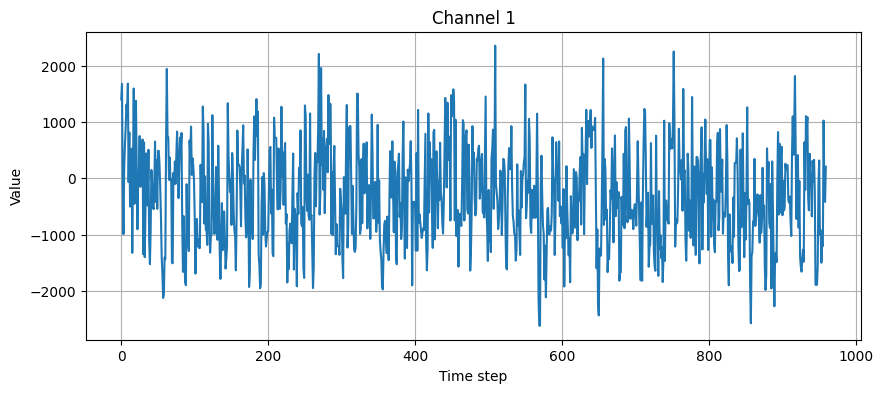

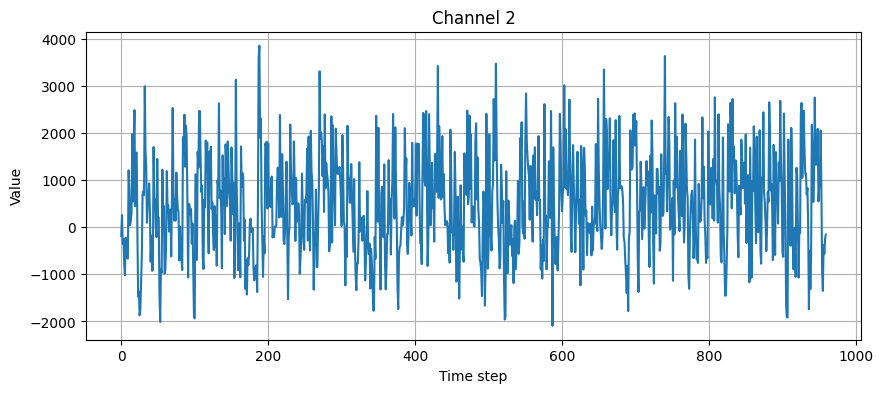

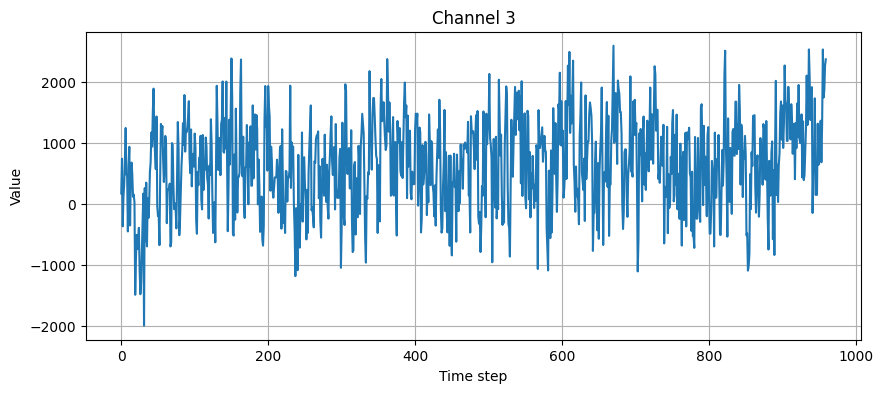

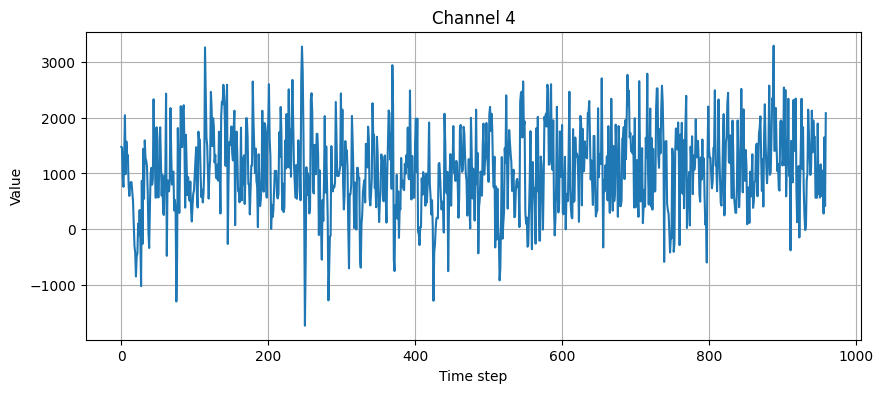

In [15]:
# prompt: plot all columns of synthetic_time_series

import matplotlib.pyplot as plt

# Assuming synthetic_time_series is a NumPy array with shape (1, time_steps, num_channels)
synthetic_time_series = synthetic_time_series[0]  # Remove the first dimension

# Plot each channel
for i in range(synthetic_time_series.shape[1]):
    plt.figure(figsize=(10, 4))
    plt.plot(synthetic_time_series[:, i])
    plt.title(f"Channel {i+1}")
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

# Save the model to pickle file

In [17]:
# prompt: save the above gan model using pickle

import pickle

# Save the generator model
with open('conditional_generator_model.pkl', 'wb') as file:
    pickle.dump(conditional_generator, file, protocol=4)

# Save the discriminator model
with open('conditional_discriminator_model.pkl', 'wb') as file:
    pickle.dump(conditional_discriminator, file, protocol=4)

# Save the GAN model
with open('conditional_gan_model.pkl', 'wb') as file:
    pickle.dump(conditional_gan, file, protocol=4)